In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from src.scripts.merge_cmu import clean_cmu
from src.scripts.category_analysis import *

In [2]:
# Install colorcet if not already installed
%pip install colorcet
import colorcet as cc

Note: you may need to restart the kernel to use updated packages.


## Load Dataset Merged CMU-IMDB

In [3]:
# Load the dataset CMU
cmu_movies = clean_cmu("MovieSummaries/movie.metadata.tsv")

# Load the dataset merge_imdb
df = pd.read_csv('data/merge_imdb.csv')
df.head()

,imdbID,isAdult,movie_name,movie_date,box_office,runtime,language,countries,genres,author_book,year_book,rating,numVotes
0,tt0000679,0,thefairylogueandradio-plays,1908,NaN,120.0,English Language,United States of America,"Silent film, Black-and-white",L. Frank Baum,1900,5.2,76
1,tt0002646,0,atlantis,1913,NaN,113.0,"English Language, Danish Language",Denmark,"Silent film, Drama, Indie, Black-and-white",Gerhart Hauptmann,1912,6.5,500
2,tt0003022,0,ivanhoe,1913,NaN,NaN,"Silent film, English Language",United States of America,"Swashbuckler films, Silent film, Drama, Adventure",Sir Walter Scott,1820,5.6,97
3,tt0004099,0,"hismajesty,thescarecrowofoz",1914,NaN,60.0,English Language,United States of America,"Silent film, Adventure, Children's/Family, Bla...",L. Frank Baum,1900,5.3,533
4,tt0004182,0,thejungle,1914,NaN,NaN,"Silent film, English Language",NaN,Silent film,Upton Sinclair,1906,6.8,70


## Basic dataset analysis

In [4]:
# Display basic information about the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940 entries, 0 to 1939
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imdbID       1940 non-null   object 
 1   isAdult      1940 non-null   int64  
 2   movie_name   1940 non-null   object 
 3   movie_date   1940 non-null   int64  
 4   box_office   767 non-null    float64
 5   runtime      1844 non-null   float64
 6   language     1865 non-null   object 
 7   countries    1914 non-null   object 
 8   genres       1936 non-null   object 
 9   author_book  1934 non-null   object 
 10  year_book    1927 non-null   object 
 11  rating       1940 non-null   float64
 12  numVotes     1940 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 197.2+ KB
None


In [5]:
# Display summary statistics of the dataframe
print(df.describe())

       isAdult   movie_date    box_office      runtime       rating  \
count   1940.0  1940.000000  7.670000e+02  1844.000000  1940.000000   
mean       0.0  1970.638144  7.499160e+07   108.494441     6.490567   
std        0.0    25.591446  1.403513e+08    28.504095     0.952388   
min        0.0  1908.000000  4.606000e+04     1.250000     1.500000   
25%        0.0  1952.000000  6.525994e+06    92.000000     5.900000   
50%        0.0  1971.000000  2.392850e+07   104.000000     6.600000   
75%        0.0  1993.000000  8.726947e+07   119.000000     7.100000   
max        0.0  2013.000000  1.119930e+09   366.000000     9.200000   

           numVotes  
count  1.940000e+03  
mean   5.690116e+04  
std    1.828976e+05  
min    6.000000e+00  
25%    1.057000e+03  
50%    5.211000e+03  
75%    3.082025e+04  
max    2.393516e+06  


In [6]:
# Check for missing values
print(df.isnull().sum())

imdbID            0
isAdult           0
movie_name        0
movie_date        0
box_office     1173
runtime          96
language         75
countries        26
genres            4
author_book       6
year_book        13
rating            0
numVotes          0
dtype: int64


In [7]:
# Display the column names
print(df.columns)

Index(['imdbID', 'isAdult', 'movie_name', 'movie_date', 'box_office',
       'runtime', 'language', 'countries', 'genres', 'author_book',
       'year_book', 'rating', 'numVotes'],
      dtype='object')


In [8]:
# Display basic statistics for each column in the dataframe
print(df.describe(include='all'))

           imdbID  isAdult          movie_name   movie_date    box_office  \
count        1940   1940.0                1940  1940.000000  7.670000e+02   
unique       1940      NaN                1699          NaN           NaN   
top     tt0000679      NaN  thethreemusketeers          NaN           NaN   
freq            1      NaN                   8          NaN           NaN   
mean          NaN      0.0                 NaN  1970.638144  7.499160e+07   
std           NaN      0.0                 NaN    25.591446  1.403513e+08   
min           NaN      0.0                 NaN  1908.000000  4.606000e+04   
25%           NaN      0.0                 NaN  1952.000000  6.525994e+06   
50%           NaN      0.0                 NaN  1971.000000  2.392850e+07   
75%           NaN      0.0                 NaN  1993.000000  8.726947e+07   
max           NaN      0.0                 NaN  2013.000000  1.119930e+09   

            runtime          language                 countries genres  \
c

## Book-to-movie analysis by categories
We begin our analysis by exploring the types of books that are most frequently adapted into movies. We want to understand which literacy works resonate with filmakers and audiences. 


In [9]:
adaptation_category_counts = analysis_by_category(df)
cmu_category_counts = analysis_by_category(cmu_movies)

In [10]:
# Convert counts in percentage
adaptation_category_perc = adaptation_category_counts.apply(lambda x: (x/len(df) * 100))
cmu_category_perc = cmu_category_counts.apply(lambda x: (x/len(cmu_movies) *100))

In [11]:
# Convert in DataFrame and merge to compare
df_adaptation_category = pd.DataFrame(adaptation_category_perc, columns=['count'])
df_cmu_category = pd.DataFrame(cmu_category_perc, columns=['count'])

adaptation_vs_cmu_categories = pd.merge(df_adaptation_category, df_cmu_category, left_index=True, right_index=True)
adaptation_vs_cmu_categories.columns = ['Adaptation', 'Movie']

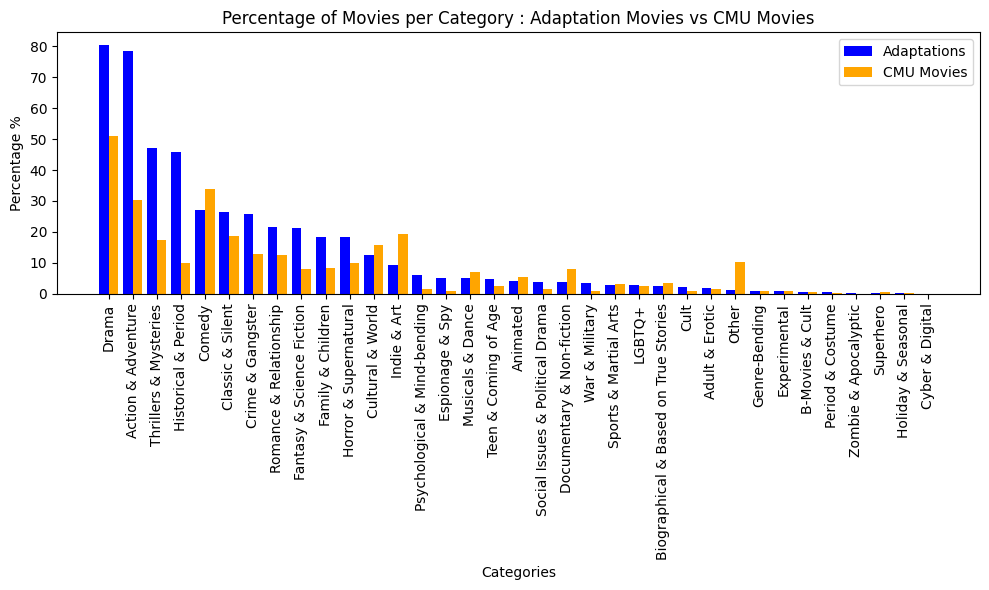

In [12]:
# Comparison Adaptation vs Movies Main Categories
index = range(len(adaptation_vs_cmu_categories))
bar_width = 0.4  # Width of the bars
plt.figure(figsize=(10, 6))
# Plot the adaptation dataset
plt.bar(index, adaptation_vs_cmu_categories['Adaptation'], width=bar_width, label='Adaptations', color='blue')
# Plot the movie dataset
plt.bar([i + bar_width for i in index], adaptation_vs_cmu_categories['Movie'], width=bar_width, label='CMU Movies', color='orange')

plt.xlabel('Categories')
plt.ylabel('Percentage %')
plt.title('Percentage of Movies per Category : Adaptation Movies vs CMU Movies')
plt.xticks([i + bar_width / 2 for i in index], adaptation_vs_cmu_categories.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


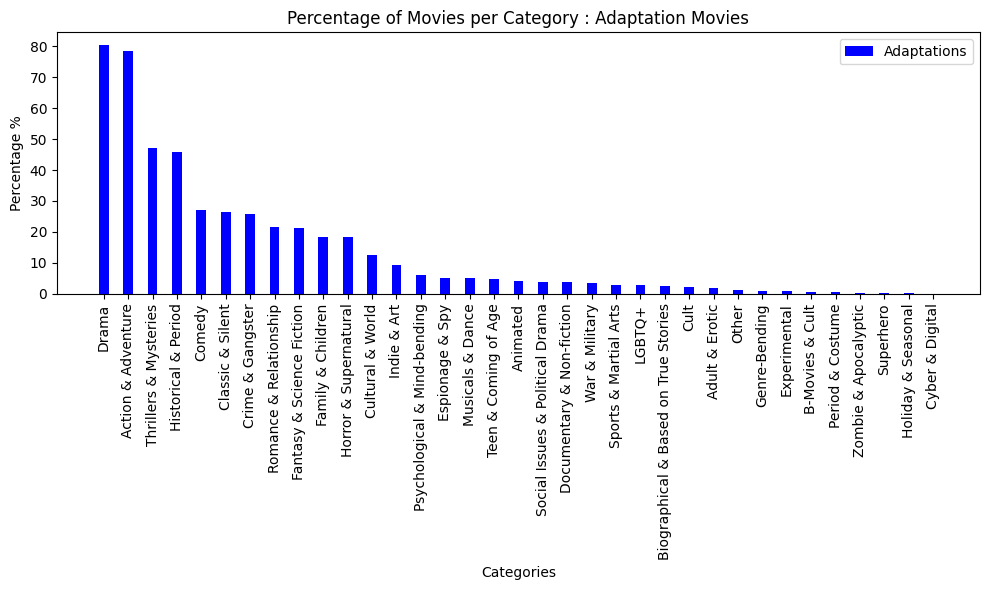

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(index, adaptation_vs_cmu_categories['Adaptation'], width=bar_width, label='Adaptations', color='blue')
plt.xlabel('Categories')
plt.ylabel('Percentage %')
plt.title('Percentage of Movies per Category : Adaptation Movies')
plt.xticks([i for i in index], adaptation_vs_cmu_categories.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

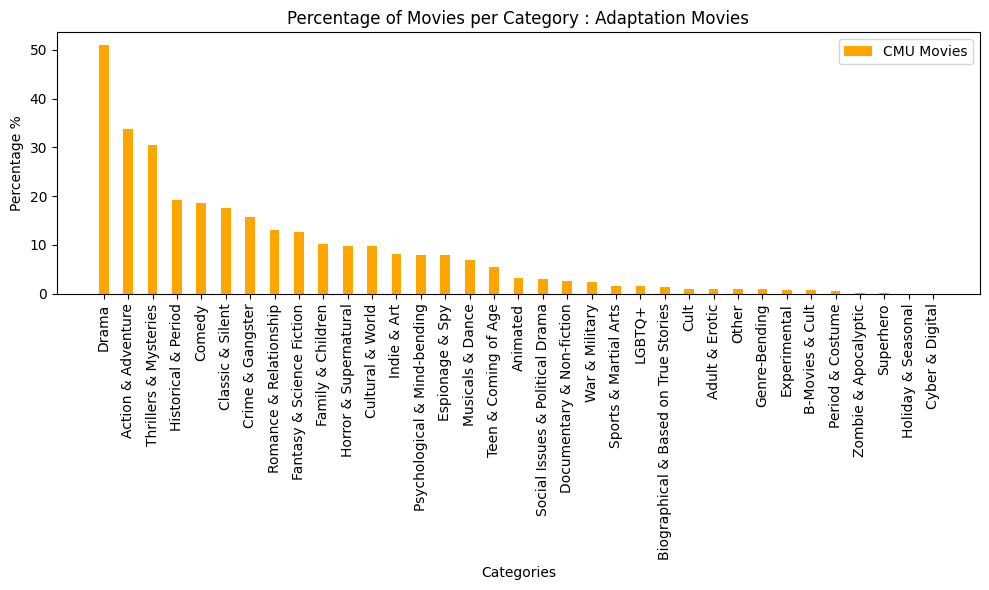

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(index, adaptation_vs_cmu_categories['Movie'].sort_values(ascending=False), width=bar_width, label='CMU Movies', color='orange')
plt.xlabel('Categories')
plt.ylabel('Percentage %')
plt.title('Percentage of Movies per Category : Adaptation Movies')
plt.xticks([i for i in index], adaptation_vs_cmu_categories.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

### Average movie date for each category 
Which categories of book adaptations are gaining popularity over time?

In [15]:
#genre_categories = load_genre_categories('data/genre_categories.json')

with open('data/genre_categories.json', 'r') as file:
    genre_categories = json.load(file)

In [16]:
#df_genres_exploded = explode_genres(df)

df_genres_exploded = df.explode('genres')

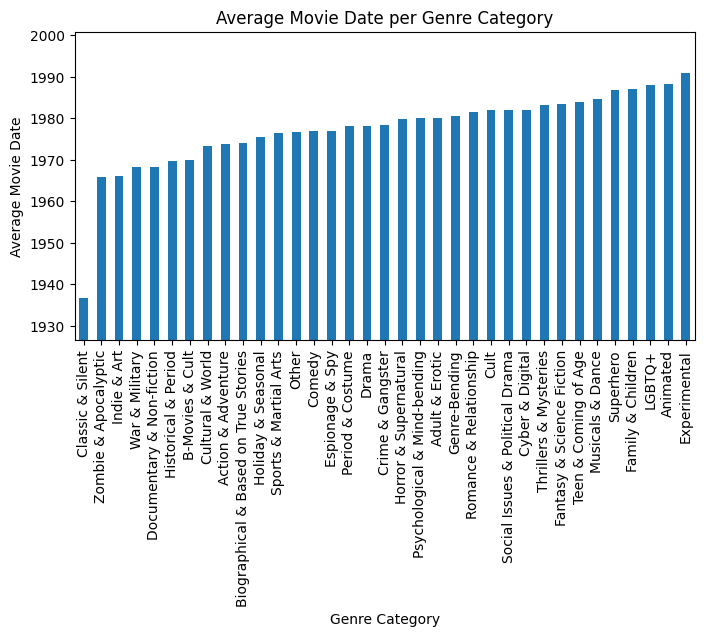

In [17]:
# Calculate the average movie date for each genre category
average_movie_date = df_genres_exploded.groupby('genres')['movie_date'].mean()

# Map genres to categories
average_movie_date_category = average_movie_date.reset_index()
average_movie_date_category['category'] = average_movie_date_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average movie date for each category
average_movie_date_category = average_movie_date_category.groupby('category')['movie_date'].mean()

# Sort the average movie date by descending order
average_movie_date_category = average_movie_date_category.sort_values(ascending=True)

# Plot the average movie date for each genre category
plt.figure(figsize=(8, 4))
average_movie_date_category.plot(kind='bar')
plt.title('Average Movie Date per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Movie Date')
plt.xticks(rotation=90)
plt.ylim(average_movie_date_category.min() - 10, average_movie_date_category.max() + 10)
plt.show()

### Average box office for each genre category
Which genre category has attracted the most attention based on box office performance?\
Although this analysis is very simple, we are planning to conduct a more detailed analysis, taking into account the inflation for instance, to give a  more accurate picture of box office trends.

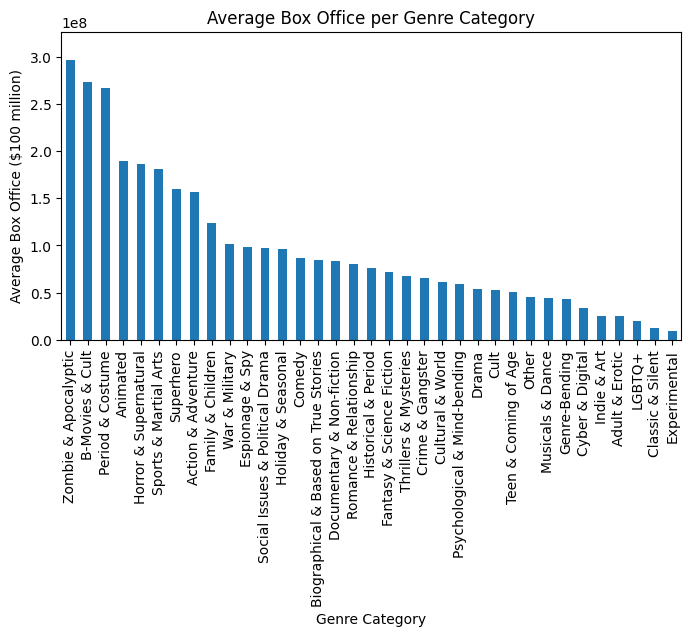

In [18]:
# Calculate the average box office for each genre category
average_box_office = df_genres_exploded.dropna(subset=['box_office']).groupby('genres')['box_office'].mean()

# Map genres to categories
average_box_office_category = average_box_office.reset_index()
average_box_office_category['category'] = average_box_office_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average box office for each category
average_box_office_category = average_box_office_category.groupby('category')['box_office'].mean()

# Sort the average box office by descending order
average_box_office_category = average_box_office_category.sort_values(ascending=False)

# Plot the average box office for each genre category
plt.figure(figsize=(8, 4))
average_box_office_category.plot(kind='bar')
plt.title('Average Box Office per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Box Office ($100 million)')
plt.xticks(rotation=90)
plt.ylim(0, average_box_office_category.max() + average_box_office_category.max()/10)
plt.show()

To account for the inflation, we take 1908 as the reference year :


Source : https://www.officialdata.org/us/inflation/1908?endYear=2013&amount=1

Min movie_date: 1908
Max movie_date: 2013


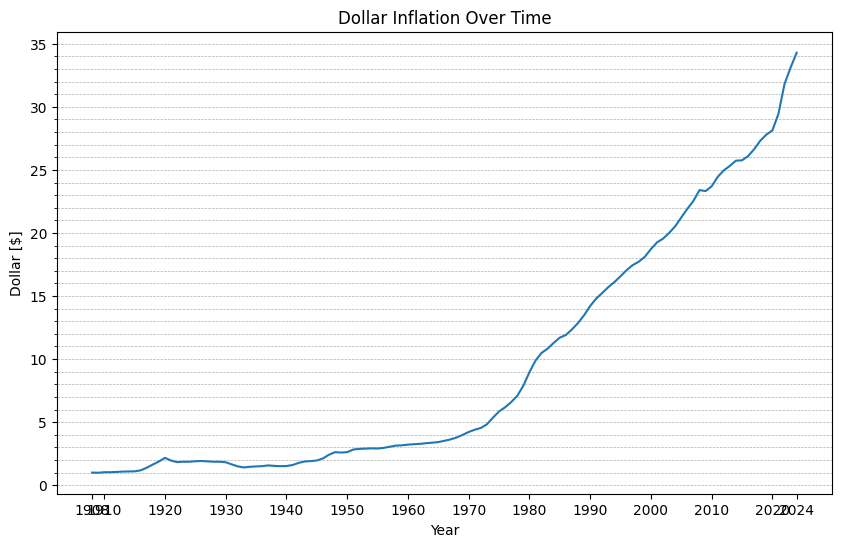

In [19]:
from matplotlib.ticker import AutoMinorLocator

min_date = df['movie_date'].min()
max_date = df['movie_date'].max()

print(f"Min movie_date: {min_date}")
print(f"Max movie_date: {max_date}")

# Load the dollar inflation data
inflation_data = pd.read_csv('data/dollar_inflation.csv')

# Plot the inflation data
plt.figure(figsize=(10, 6))
plt.plot(inflation_data['year'], inflation_data['inflation'])
plt.title('Dollar Inflation Over Time')
plt.xlabel('Year')
plt.ylabel('Dollar [$]')
plt.grid(which='both', axis='y', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.xticks(list(range(1910, 2024, 10)) + [1908, 2024])  # Set x-ticks every 10 years, plus 1908 and 2024
plt.show()

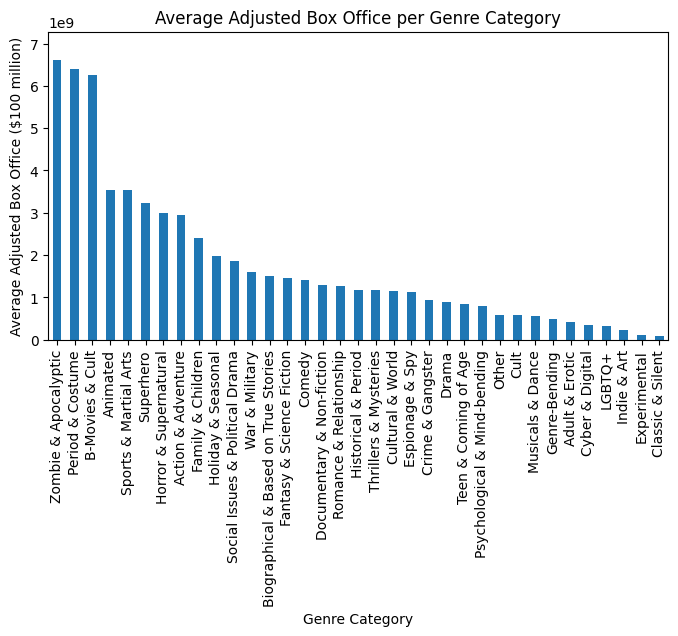

In [20]:
# Merge df_genres_exploded with inflation_data on the column movie_date and year
df_merged_genres_inflation = pd.merge(df_genres_exploded, inflation_data, left_on='movie_date', right_on='year')

# Display the first few rows of the merged dataframe
df_merged_genres_inflation.head()

# Calculate the adjusted box office for each movie
df_merged_genres_inflation['adjusted_box_office'] = df_merged_genres_inflation['box_office'] * df_merged_genres_inflation['inflation']

# Calculate the average adjusted box office for each genre category
average_adjusted_box_office = df_merged_genres_inflation.dropna(subset=['adjusted_box_office']).groupby('genres')['adjusted_box_office'].mean()

# Map genres to categories
average_adjusted_box_office_category = average_adjusted_box_office.reset_index()
average_adjusted_box_office_category['category'] = average_adjusted_box_office_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average adjusted box office for each category
average_adjusted_box_office_category = average_adjusted_box_office_category.groupby('category')['adjusted_box_office'].mean()

# Sort the average adjusted box office by descending order
average_adjusted_box_office_category = average_adjusted_box_office_category.sort_values(ascending=False)

# Plot the average adjusted box office for each genre category
plt.figure(figsize=(8, 4))
average_adjusted_box_office_category.plot(kind='bar')
plt.title('Average Adjusted Box Office per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Adjusted Box Office ($100 million)')
plt.xticks(rotation=90)
plt.ylim(0, average_adjusted_box_office_category.max() + average_adjusted_box_office_category.max()/10)
plt.show()

### Average runtime for each category 
Although this would need further investigation, analyzing the runtime of book-to-movie adaptations by category can provide insight into how different genres balance storytelling depth and audience expectations. It can highlight the compromises between narrative compression and fidelity to the source material.

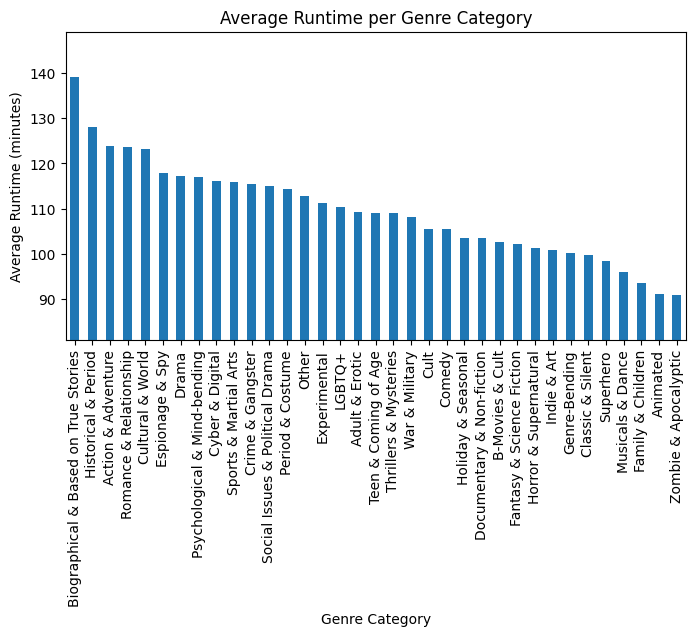

In [21]:
# Calculate the average runtime for each genre category
average_runtime = df_genres_exploded.dropna(subset=['runtime']).groupby('genres')['runtime'].mean()

# Map genres to categories
average_runtime_category = average_runtime.reset_index()
average_runtime_category['category'] = average_runtime_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average runtime for each category
average_runtime_category = average_runtime_category.groupby('category')['runtime'].mean()

# Sort the average runtime by descending order
average_runtime_category = average_runtime_category.sort_values(ascending=False)

# Plot the average runtime for each genre category
plt.figure(figsize=(8, 4))
average_runtime_category.plot(kind='bar')
plt.title('Average Runtime per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Runtime (minutes)')
plt.xticks(rotation=90)
plt.ylim(average_runtime_category.min() - 10, average_runtime_category.max() + 10)
plt.show()

## Book-to-movie analysis by language and category
This analysis examines the distribution of movies across different genre categories and languages. This can provide insights into how genre preferences vary across linguistic contexts, potentially reflecting cultural influences. 

In [22]:
# Separate the languages by each comma and explode the list into separate rows
df_genres_exploded['language'] = df_genres_exploded['language'].str.split(', ')
df_genres_exploded_languages_exploded = df_genres_exploded.explode('language')

# Clean the languages by removing the word "Language"
df_genres_exploded_languages_exploded['language'] = df_genres_exploded_languages_exploded['language'].str.replace(' Language', '')

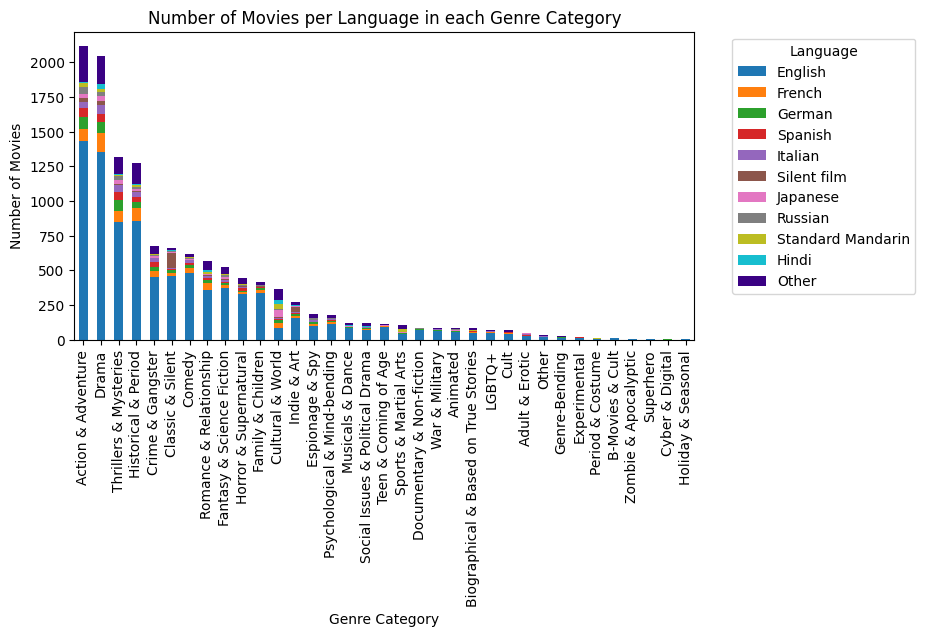

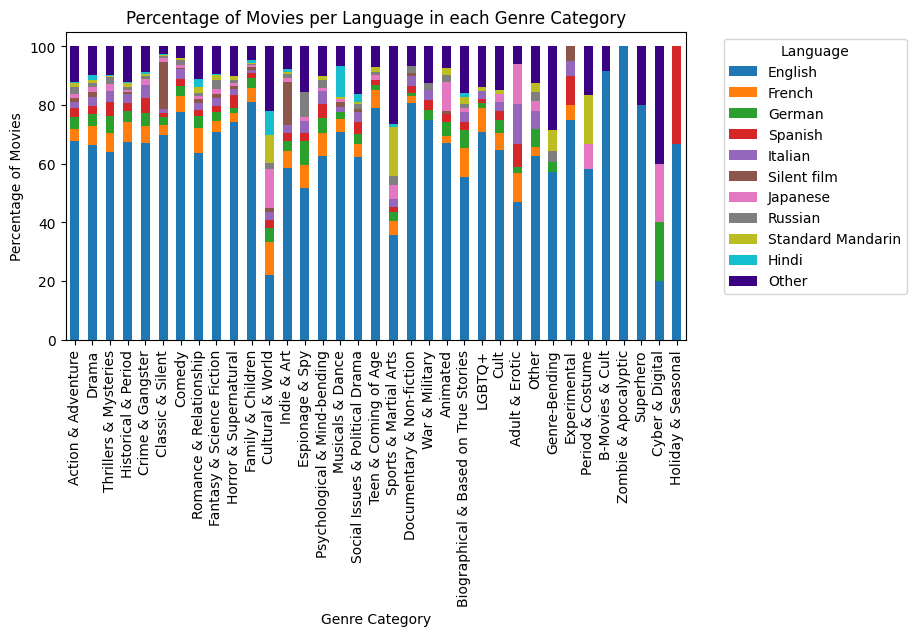

In [23]:
# Group by genre categories and languages, and count the number of movies in each combination
language_counts = df_genres_exploded_languages_exploded.groupby(['genres', 'language']).size().unstack()

# Get the top 10 most used languages
top_languages = language_counts.sum().sort_values(ascending=False).head(10).index

# Map genres to categories
language_counts['category'] = language_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and languages, and count the number of movies in each combination
language_counts = language_counts.groupby('category').sum()

# Keep only the top 10 languages and group the rest into 'Other'
language_counts['Other'] = language_counts.drop(columns=top_languages).sum(axis=1)
language_counts = language_counts[top_languages.tolist() + ['Other']]

# Sort the genre categories by the total number of movies in descending order
language_counts = language_counts.loc[language_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart
unique_languages = language_counts.columns
colors = sns.color_palette(cc.glasbey_category10, n_colors=len(unique_languages))  # Get a unique color for each language

language_counts[unique_languages].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Number of Movies per Language in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculate the percentage of movies in each language for each genre category
language_counts_percentage = language_counts.div(language_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart by percentage
language_counts_percentage[unique_languages].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Percentage of Movies per Language in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=90)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Book-to-movie analysis by country and category


In [24]:
# Separate the countries by each comma and explode the list into separate rows
df_genres_exploded['countries'] = df_genres_exploded['countries'].str.split(', ')
df_genres_exploded_countries_exploded = df_genres_exploded.explode('countries')

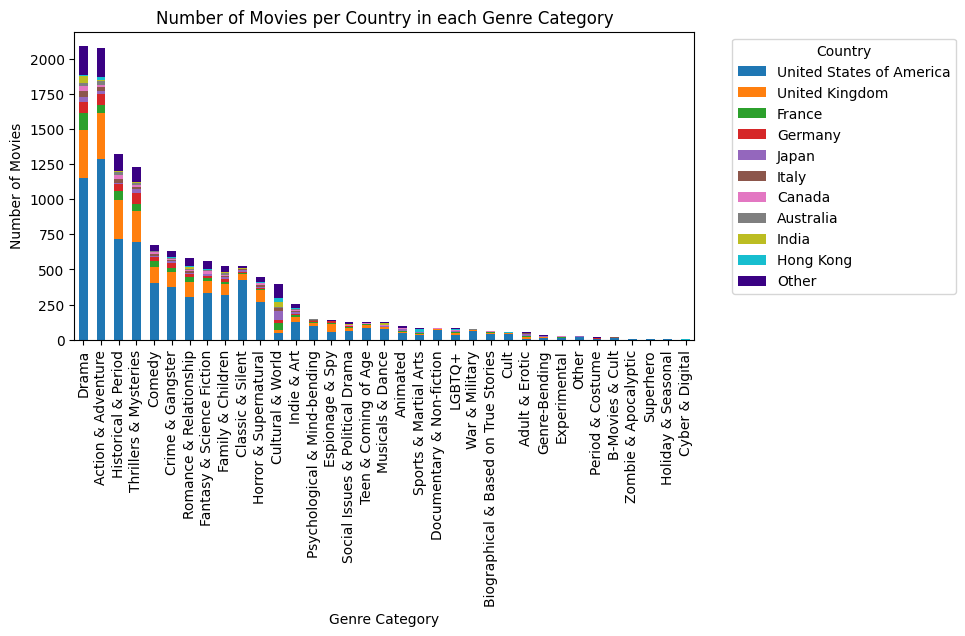

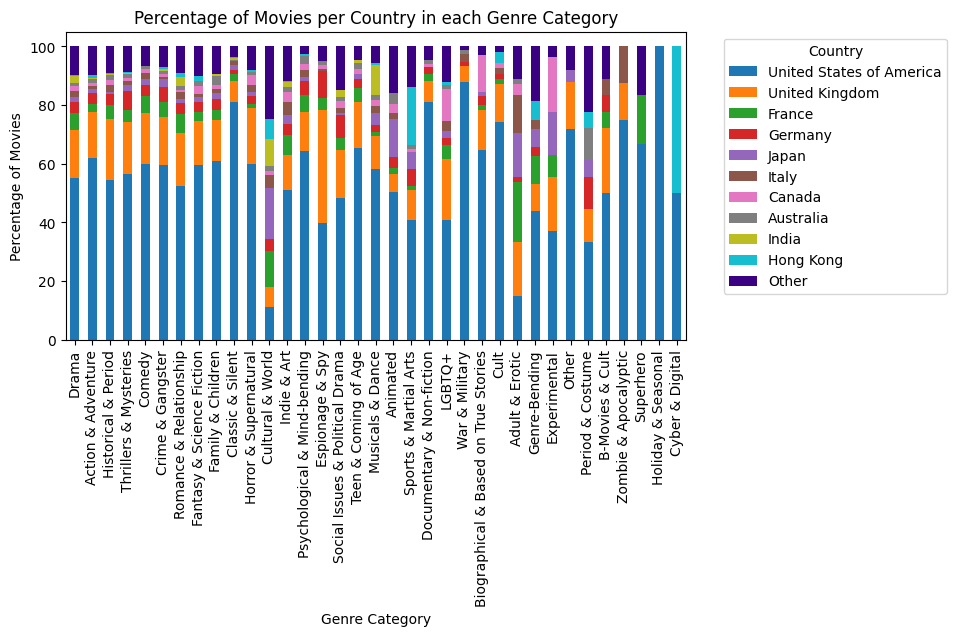

In [25]:
# Group by genre categories and countries, and count the number of movies in each combination
country_counts = df_genres_exploded_countries_exploded.groupby(['genres', 'countries']).size().unstack()

# Get the top 10 most used countries
top_countries = country_counts.sum().sort_values(ascending=False).head(10).index

# Map genres to categories
country_counts['category'] = country_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and countries, and count the number of movies in each combination
country_counts = country_counts.groupby('category').sum()

# Keep only the top 10 countries and group the rest into 'Other'
country_counts['Other'] = country_counts.drop(columns=top_countries).sum(axis=1)
country_counts = country_counts[top_countries.tolist() + ['Other']]

# Sort the genre categories by the total number of movies in descending order
country_counts = country_counts.loc[country_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart
unique_countries = country_counts.columns
colors = sns.color_palette(cc.glasbey_category10, n_colors=len(unique_countries))  # Get a unique color for each country

country_counts[unique_countries].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Number of Movies per Country in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculate the percentage of movies in each country for each genre category
country_counts_percentage = country_counts.div(country_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart by percentage
country_counts_percentage[unique_countries].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Percentage of Movies per Country in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=90)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Authors Cherished by the World of Cinema
This analysis highlights authors whose works have inspired the most movie adaptations. This can offer insights into literary trends that are particularly popular in cinema.

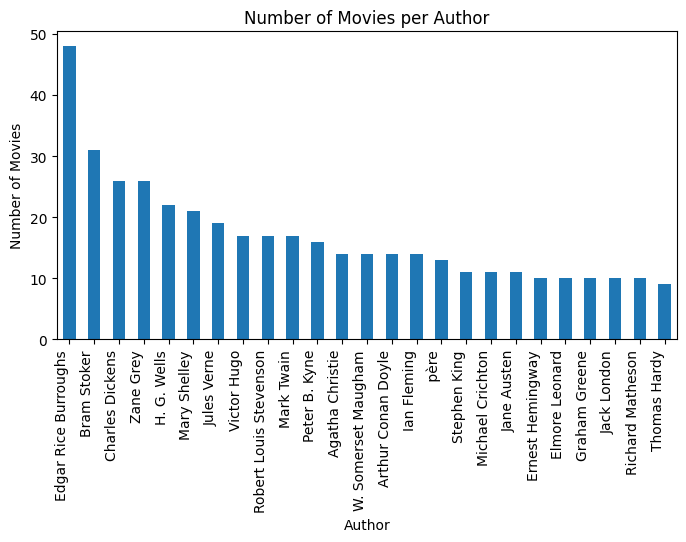

In [26]:
# Get the top 10 authors by the number of movies
top_authors = df['author_book'].value_counts().head(25)

# Plot the bar chart
plt.figure(figsize=(8, 4))
top_authors.plot(kind='bar')
plt.title('Number of Movies per Author')
plt.xlabel('Author')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')
plt.show()

## Number of adaptations from books made over time
This analysis could reveal periods of increased interest in book-to-movie adaptations, helping identify cultural, societal, or industry-driven factors that influenced these trends, such as shifts in audience preferences.

In [27]:
adpt_per_year = df.groupby('movie_date').size().reset_index(name='movie_count')

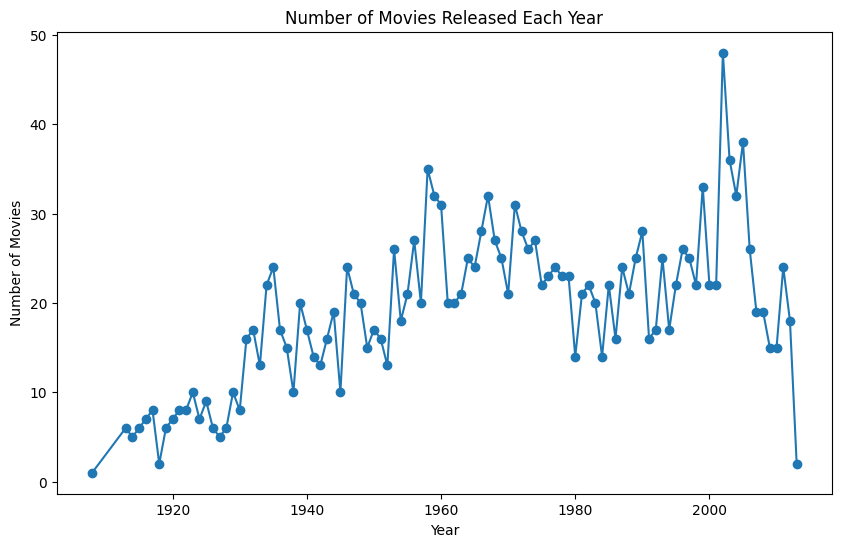

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(adpt_per_year['movie_date'], adpt_per_year['movie_count'], marker='o')

plt.title('Number of Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

## Impact of Book Release Dates on Movie Adaptations
How does the timing of a book’s release influence its cinematic potential ?\
This analysis explores the correlation between the release dates of books and the number of movie adaptations they inspire. 

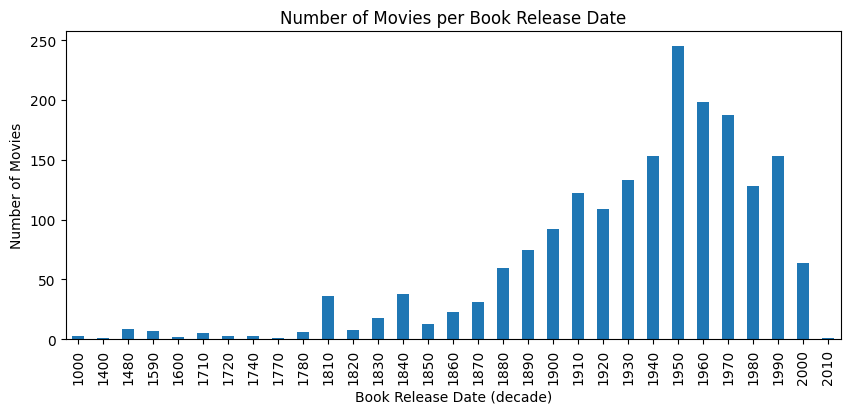

In [29]:
# Extract the first year if the date is in the format xxxx-xxxx
df['year_book'] = df['year_book'].str.split('–').str[0]
df['year_book'] = df['year_book'].str.split('-').str[0]

# Drop rows with NaN values in 'year_book'
df = df.dropna(subset=['year_book'])

# Convert 'year_book' to integer
df['year_book'] = df['year_book'].astype(int)

# Create a new column for the decade
df['decade'] = (df['year_book'] // 10) * 10

# Plot the bar chart grouped by decade
plt.figure(figsize=(10, 4))
df['decade'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Movies per Book Release Date')
plt.xlabel('Book Release Date (decade)')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()